In [1]:
import numpy as np
import json
from matplotlib import pyplot as plt, cm
import tensorflow as tf
import numpy as np

import os
import traceback

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
import tensorflow.keras.activations as tf_act

from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.scorecam import Scorecam
        
from inpaint import inpaint

In [2]:
def cnv_lst_arr(lst):
    ''' Convert list object to array. '''
    arr = np.array(lst)
    return arr

def reset_dir():
    ''' Change the directory to root directory of project. '''
    os.chdir(ROOT_DIR)
    CURR_DIR = os.getcwd()

def change_dir(dir):
    '''
    Change the directory to specified directory.

    Args:
        dir: The directory where to set the cwd
    '''
    os.chdir(dir)
    CURR_DIR = os.getcwd()

In [3]:
class inpaint_defense:
    def __init__(self, model, CLASS_INDEX, activation_fn=tf_act.linear, patch_class='toaster'):
        '''
        Args:
            model: The pre-trained model for making predictions
            batch_size: The number of images in the dataset
            classlabel: The class label for 1000 classes
            clean_images: The batch of images without any adversarial patch [?, 224, 224, 3]
            clean_predictions: The array of predictions for images without patch [?, class_index, class, confidence]
            clean_class_lbls: The array of class index the clean image belongs to
            ground_truths: The array of actual class the images belongs to 
            adv_images: The batch of adverasrial images [?, 224, 224, 3]
            adv_predictions: The array of predictions for the adversarial image [?, class_index, object class, confidence]
            adv_class_lbls: The index of each class the image with adversarial patch belongs to
            new_predictions: The array of predictions after inpainting the adversarial image [?, class_index, object class, confidence]
            new_class_lbls: The array of class index the inpainted image belongs to
            cams: The batch of cam filter obtained for each image [?, 224, 224]
            patch_mask: The patch mask generated using a threshold value (0.5) [?, 224, 224]
            inpaint_images: The batch of images obtained after applying inpainting [?, 224, 224, 3]
            * patch_class: The patch class that we are targetting to misclassify
            Activation_fn: The activation function used for generating heatmap of salient features
        '''
        self.model = model
        self.batch_size = 0
        self.CLASS_INDEX = CLASS_INDEX
        self.clean_images = []
        self.ground_truths = []
        self.clean_class_lbls = []
        self.adv_images = []
        self.clean_predictions = []
        self.adv_predictions = []
        self.new_predictions = []
        self.adv_class_lbls = []
        self.new_class_lbls = []
        self.cams = []
        self.patch_masks = []
        self.inpaint_images = []
        self.patch_class = patch_class
        self.activ_fn = activation_fn
        
        classlabel  = []
        for i_dict in range(len(CLASS_INDEX)):
            classlabel.append(CLASS_INDEX[str(i_dict)][1])
        self.classlabel = classlabel

    def load_dataset(self, directory, show_plot=False):
        '''
        Load the dataset from given directory.

        Args:
            directory: A directory that contains folders in format:
                                    ---directory
                                        ---adv_images
                                            ---class1
                                                ---image1.jpg
                                                ---image2.jpg
                                                    ...
                                            ---class2
                                                ---image1.jpg
                                                ---image2.jpg
                                                    ...
                                                ...
                                        ---clean_images
                                            ---class1
                                                ---image1.jpg
                                                ---image2.jpg
                                                    ...
                                            ---class2
                                                ---image1.jpg
                                                ---image2.jpg
                                                    ...
                                                ...
                        Make sure the adversarial image folder start with 'adv' and clean image folder starts with 'clean'
            img_per_class: The number of images to display for each class (defaults to 2)
            show_plot: a boolean variable to determine whether to display the plots of images(default, True)
        '''
        clean_img_count = 0
        adv_img_count = 0
        try:
            img_height = 224
            img_width = 224
            
            change_dir(directory)
            for folder in os.listdir():
                data_directory = os.path.join(os.getcwd(), folder)
                images = image_dataset_from_directory(
                    data_directory,
                    seed=42, 
                    image_size=(img_height, img_width),
                    batch_size=None, # The dataset will yield individual samples.
                    color_mode='rgb')

                if folder.startswith('adv'):
                    for img, labels in images.take(-1):
                        img = img_to_array(img).astype(np.uint8)

                        self.adv_images.append(img.copy())
                        img = np.expand_dims(img, axis=0)

                        tmp_img = preprocess_input(img.copy())
                        img_pred = model.predict(tmp_img)
                        prediction = decode_predictions(img_pred, top=1)

                        class_lbl = self.classlabel.index(prediction[0][0][1])

                        self.adv_predictions.append(prediction[0][0])
                        self.adv_class_lbls.append(class_lbl)

                        adv_img_count += 1

                        if show_plot == True:
                            self.plot_images(img)

                if folder.startswith('clean'):
                    for img, labels in images.take(-1):
                        img = img_to_array(img).astype(np.uint8)

                        self.clean_images.append(img.copy())
                        img = np.expand_dims(img, axis=0)

                        tmp_img = preprocess_input(img.copy())
                        img_pred = model.predict(tmp_img)
                        prediction = decode_predictions(img_pred, top=1)

                        class_lbl = self.classlabel.index(prediction[0][0][1])

                        class_list = [itm for val in CLASS_INDEX.values() for itm in val]
                        ind = int(class_list.index(images.class_names[labels]) / 2)
                        
                        self.ground_truths.append((self.classlabel[ind]))
                        
                        self.clean_predictions.append(prediction[0][0])
                        self.clean_class_lbls.append(class_lbl)

                        clean_img_count += 1

                        if show_plot == True:
                            self.plot_images(img)

            # Determine whether tne number of clean images and adversarial images are same or not
            assert clean_img_count == adv_img_count
            self.batch_size = int(clean_img_count)

            # Convert all the list to array elements
            self.clean_images = cnv_lst_arr(self.clean_images)
            self.clean_predictions = cnv_lst_arr(self.clean_predictions)
            self.clean_class_lbls = cnv_lst_arr(self.clean_class_lbls)
            self.adv_images = cnv_lst_arr(self.adv_images)
            self.adv_predictions = cnv_lst_arr(self.adv_predictions)
            self.adv_class_lbls = cnv_lst_arr(self.adv_class_lbls)
            self.ground_truths = cnv_lst_arr(self.ground_truths)
            reset_dir()
            
        except Exception as e:
            print(traceback.format_exc())
            print(e)
            reset_dir()


    def grad_plot(self, cam, title, heatmap, index):
        '''
        Plot a graph of saliency feature generate through gradCAM.
        
        Args:
            cam: The gradcam object which generates the heatmap
            title: The title of the saliency plot
            heatmap: The heatmap that we generated using gradcam object
            index: The index of the saliency plot for respective image
        '''
        plt.title(title, fontsize=16)
        plt.imshow(np.uint8(self.adv_images[index]))
        plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def apply_cam(self, show_plot=False):
        '''
        Generates the saliency map of the given batch of images using gradient CAM technique.

        Args:
            show_plot: a boolean variable to determine whether to display the saliency map for each image(default, True)
        '''
        # When the softmax activation function is applied to the last layer of model,
        # it may obstruct generating the attention images, so you should replace the function to a linear activation function.
        def model_modifier_function(cloned_model):
            cloned_model.layers[-1].activation = self.activ_fn

        # And then, you MUST create Score instance or define score function that returns target scores.
        # Here, they return the score values corresponding to images.

        score = CategoricalScore(self.adv_class_lbls.tolist())

        image_titles = self.adv_predictions[:, 1]

        # # Create Gradcam object
        # gradcam = Gradcam(self.model, model_modifier=model_modifier_function, clone=True)
        # # Generate heatmap with GradCAM
        # cam = gradcam(score, (np.float32(self.adv_images)).copy(), penultimate_layer=-1)

        # Create Scorecam object
        scorecam = Scorecam(model, model_modifier=model_modifier_function)
        # Generate heatmap with Faster-ScoreCAM
        cam = scorecam(score, (np.float32(self.adv_images)).copy(), penultimate_layer=-1, max_N=10)

        for i, title in enumerate(image_titles):
            heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

            if show_plot == True:
                self.grad_plot(cam, title, heatmap, i)

            self.cams.append(cam[i].copy())

        self.cams = cnv_lst_arr(self.cams)

    def mask_plot(self, img):
        '''
        Function that plots the mask generated for the image.

        Args:
            img: The mask image to print
        '''
        plt.imshow(np.uint8(img), cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def gen_mask(self, show_plot=False):
        ''' Generates a binary mask from saliency map obtained for every image in the given batch.'''

        for ind in range(self.cams.shape[0]):

            temp_cam = self.cams[ind].copy()        

            binary_patch_mask = []
            binary_patch_mask = np.where(temp_cam >= 0.5, 1., 0.) # 1. - (temp_cam.mean())

            self.patch_masks.append(np.array(binary_patch_mask))

            if show_plot == True:
                self.mask_plot(binary_patch_mask)

        self.patch_masks = cnv_lst_arr(self.patch_masks)

    def apply_inpaint(self, show_plot=False):
        '''
        Applies inpainting technique toremove adversarial patch from the images in the given batch.
        Also gives a plot of images obtained after inpainting along with class predictions

        Args:
            show_plot: a boolean variable to determine whether to show plot of new prediction obtained after applying inpainting technique(default, True)
        '''
        for ind in range(self.adv_images.shape[0]):

            inpaint_img = (self.adv_images[ind]).copy()

            src_img = inpaint_img
            img = inpaint_img
            mask = self.patch_masks[ind]

            inpaint_img = inpaint(src_img, img, mask)

            self.inpaint_images.append(inpaint_img)

            inpaint_img = np.expand_dims(inpaint_img.copy(), axis=0)

            # Find new predictions after inpainting
            tmp_img = preprocess_input(inpaint_img.copy())
            img_pred = model.predict(tmp_img)
            prediction = decode_predictions(img_pred, top=1)
            class_lbl = self.classlabel.index(prediction[0][0][1])

            self.new_predictions.append(prediction[0][0])
            self.new_class_lbls.append(class_lbl)

            if show_plot == True:
                self.plot_images(inpaint_img)

        # Convert all the list to array elements
        self.inpaint_images = cnv_lst_arr(self.inpaint_images)
        self.new_predictions = cnv_lst_arr(self.new_predictions)
        self.new_class_lbls = cnv_lst_arr(self.new_class_lbls)


    def plot_images(self, img):
        '''
        Plot the image with title as the prediction class, confidence and its class label.

        Args:
            img: The imaeg to be plotted [1, 224, 224, 3]
        '''
         # Find new predictions after inpainting
        tmp_img = preprocess_input(img.copy())
        img_pred = model.predict(tmp_img)
        prediction = decode_predictions(img_pred, top=1)
        class_lbl = self.classlabel.index(prediction[0][0][1])

        # Rendering
        plt.figure(figsize=(3, 4))
        plt.title(f'Prediction: {prediction[0][0][1]}({prediction[0][0][2]:1.3})\nLabel: {class_lbl}')
        plt.imshow(np.uint8(img[0]))
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def generate_inpaint(self, grad_flag=False, mask_flag=False, inpaint_flag=False):
        '''
        A function that performs the given tasks in sequential order. 

        Args:
            grad_plot: Indicates if we want to display the plot of gradient cam
            mask_flag: Indicates if we want to display the plot of mask obtained
            inpaint_flag: Indicates if we want to display the plot of inapint images
        '''
        # After loading od fata is done, generate its saliency map using grad CAM technique
        self.apply_cam(show_plot=grad_flag)

        # genearate a mask by setting a threshold value 
        self.gen_mask(show_plot=mask_flag)

        # Apply inpainting technique and get predictions for class
        self.apply_inpaint(show_plot=inpaint_flag)

    def plot_data(self, index):
        '''
        Plots the graph of following:
            1. Original image
            2. Its heatmap generated using Scorecam
            3. The binary mask generated from the heatmap
            4. The final image after applying inpainting technique

        Args:
            index: The index of the image to print the plots
        '''
        fig, axes = plt.subplots(1, 5, figsize=(12, 7))
        fig.tight_layout()

        axes[0].imshow(self.clean_images[index])
        axes[0].set_title(f'Clean Prediction\n{self.clean_predictions[index][1]}({self.clean_predictions[index][2].astype(np.float32):1.3f})\nLabel: {self.clean_class_lbls[index]}')
        axes[0].axis('off')

        axes[1].imshow(self.adv_images[index])
        axes[1].set_title(f'Adv Prediction\n{self.adv_predictions[index][1]}({self.adv_predictions[index][2].astype(np.float32):1.3f})\nLabel: {self.adv_class_lbls[index]}')
        axes[1].axis('off')

        axes[2].imshow(self.cams[index])
        axes[2].set_title('Heatmap of\nsalient feature')
        axes[2].axis('off')

        axes[3].imshow(self.patch_masks[index], cmap='gray')
        axes[3].set_title('Binary mask\nfor inpainting')
        axes[3].axis('off')

        axes[4].imshow(self.inpaint_images[index])
        axes[4].set_title(f'Inpaint Prediction\n{self.new_predictions[index][1]}({self.new_predictions[index][2].astype(np.float32):1.3f})\nLabel: {self.new_class_lbls[index]}')
        axes[4].axis('off')

    def defense_accuracy(self):
        '''
        Calculate the following accuracies:
            1. Clean accuracy of the model
            2. Misclassification accuracy of the patch
            3. Inpainting accuracy after applying diffusion technique
        '''
        correct_clean = 0
        correct_adv = 0
        correct_new = 0
        n_success = 0
        n_samples = self.batch_size
        
        for index in range(self.batch_size):
            correct_clean += self.ground_truths[index] == self.clean_predictions[:, 1][index]
            
            correct_adv += self.ground_truths[index] == self.adv_predictions[:, 1][index]
            
            correct_new += self.ground_truths[index] == self.new_predictions[:, 1][index]
            
        clean_accuracy = 100 * (correct_clean / n_samples)
        misclassification_accuracy = 100 * (1 - correct_adv / n_samples)
        inpaint_accuracy = 100*(correct_new / n_samples)
        
        print(f'Clean accuracy: {clean_accuracy:>0.2f}%')
        print(f'Patch success accuracy: {misclassification_accuracy:>0.2f}%')
        print(f'Inpainting Accuracy: {inpaint_accuracy:>0.2f}%')

In [4]:
# Load model
Model = ResNet50
model = Model(weights='imagenet')

# global parameters
ROOT_DIR = os.getcwd()
CURR_DIR = os.getcwd()

# Download the json file of list of classes in imagenet with index
if os.path.isfile('imagenet_class_index.json') == False:
    !wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

CLASS_INDEX = json.load(open("imagenet_class_index.json"))

## Testing on 2 images

Found 2 files belonging to 2 classes.
1/1 [==============================] - 0s 133ms/step
Found 2 files belonging to 2 classes.
1/1 [==============================] - 0s 143ms/step


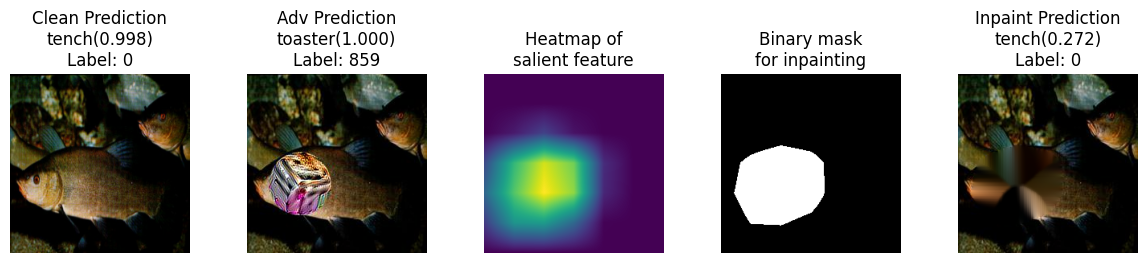

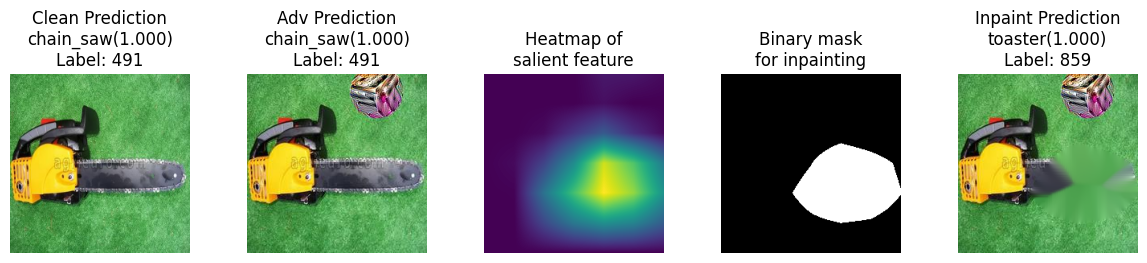

Clean accuracy: 100.00%
Patch success accuracy: 50.00%
Inpainting Accuracy: 50.00%


In [18]:
# Using linear output layer
id_test = inpaint_defense(model, CLASS_INDEX)
id_test.load_dataset('test_data')

id_test.generate_inpaint()

for i in range(id_test.batch_size):
    id_test.plot_data(i)
    plt.show()

id_test.defense_accuracy()

In [6]:
# Using reLU output layer
id_test = inpaint_defense(model, CLASS_INDEX, tf_act.relu)
id_test.load_dataset('test_data')

id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
#     plt.show()


id_test.defense_accuracy()

Found 2 files belonging to 2 classes.
1/1 [==============================] - 0s 146ms/step
Found 2 files belonging to 2 classes.
1/1 [==============================] - 0s 139ms/step
Clean accuracy: 100.00%
Patch success accuracy: 50.00%
Inpainting Accuracy: 50.00%


Found 2 files belonging to 2 classes.
1/1 [==============================] - 0s 141ms/step
Found 2 files belonging to 2 classes.
1/1 [==============================] - 0s 141ms/step


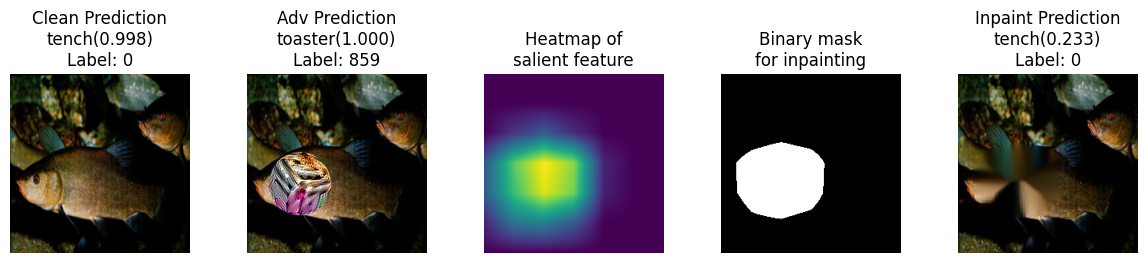

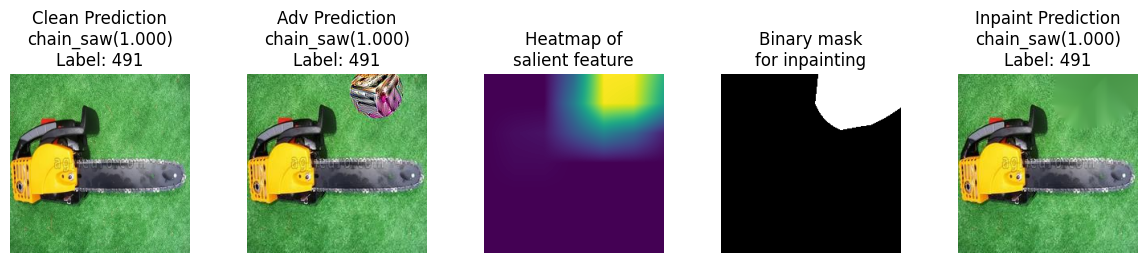

In [19]:
# Using tanh output layer
id_test = inpaint_defense(model, CLASS_INDEX, tf_act.tanh)
id_test.load_dataset('test_data')

id_test.generate_inpaint()

for i in range(id_test.batch_size):
    id_test.plot_data(i)
    plt.show()

## Patched image dataset of 50 images

In [9]:
# Using linear activation function
id1 = inpaint_defense(model, CLASS_INDEX)
id1.load_dataset('dataset_adv_x.30')

id1.generate_inpaint()

# for i in range(id1.batch_size):
#     id1.plot_data(i)

id1.defense_accuracy()

Found 39 files belonging to 4 classes.
1/1 [==============================] - 0s 156ms/step
Found 39 files belonging to 4 classes.
1/1 [==============================] - 0s 134ms/step
Clean accuracy: 92.31%
Patch success accuracy: 89.74%
Inpainting Accuracy: 66.67%


In [17]:
# Using relu activation function
id1 = inpaint_defense(model, CLASS_INDEX, tf_act.relu)
id1.load_dataset('dataset_adv_x.30')

id1.generate_inpaint()

# for i in range(id1.batch_size):
#     id1.plot_data(i)


id1.defense_accuracy()

Found 39 files belonging to 4 classes.
1/1 [==============================] - 0s 132ms/step
Found 39 files belonging to 4 classes.
1/1 [==============================] - 0s 141ms/step
Clean accuracy: 92.31%
Patch success accuracy: 89.74%
Inpainting Accuracy: 66.67%


In [12]:
# Using tanh activation function
id1 = inpaint_defense(model, CLASS_INDEX, tf_act.tanh)
id1.load_dataset('dataset_adv_x.30')

id1.generate_inpaint()

# for i in range(id1.batch_size):
#     id1.plot_data(i)


id1.defense_accuracy()

Found 39 files belonging to 4 classes.
1/1 [==============================] - 0s 129ms/step
Found 39 files belonging to 4 classes.
1/1 [==============================] - 0s 125ms/step
Clean accuracy: 92.31%
Patch success accuracy: 89.74%
Inpainting Accuracy: 74.36%
